# RTMPose三角板关键点检测预测-Python API

同济子豪兄 2023-4-4

## 进入 mmpose 主目录

In [1]:
import os
os.chdir('mmpose')

## 导入工具包

In [2]:
import cv2
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

import torch

import mmcv
from mmcv import imread
import mmengine
from mmengine.registry import init_default_scope

from mmpose.apis import inference_topdown
from mmpose.apis import init_model as init_pose_estimator
from mmpose.evaluation.functional import nms
from mmpose.registry import VISUALIZERS
from mmpose.structures import merge_data_samples

from mmdet.apis import inference_detector, init_detector

In [3]:
# 有 GPU 就用 GPU，没有就用 CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device', device)

device cuda:0


## 载入待测图像

In [4]:
img_path = 'data/test_triangle/triangle_4.jpg'

In [5]:
# Image.open(img_path)

## 构建目标检测模型

In [6]:
# RTMDet 三角板目标检测
import os
os.chdir('../mmdetection')

# RTMDet 三角板检测
detector = init_detector(
    'data/rtmdet_tiny_triangle.py',
    'checkpoint/rtmdet_tiny_epoch_500.pth',
    device=device
)

os.chdir('../mmpose')

Loads checkpoint by local backend from path: checkpoint/rtmdet_tiny_epoch_500.pth


In [6]:
# Faster R CNN 三角板目标检测
detector = init_detector(
    'data/faster_r_cnn_triangle.py',
    'checkpoint/faster_r_cnn_triangle_epoch_50.pth',
    device=device
)

Loads checkpoint by local backend from path: checkpoint/faster_r_cnn_triangle_epoch_50.pth
04/04 22:30:40 - mmengine - WARNING - sjb_rect is not a meta file, simply parsed as meta information


## 构建关键点检测模型

In [7]:
pose_estimator = init_pose_estimator(
    'data/rtmpose-s_triangle_8xb256-420e_coco-256x192.py',
    'checkpoint/rtmpose_slim-9888686d_20230403.pth',
    device=device,
    cfg_options={'model': {'test_cfg': {'output_heatmaps': True}}}
)

Loads checkpoint by local backend from path: checkpoint/rtmpose_slim-9888686d_20230403.pth


## 预测-目标检测

In [8]:
init_default_scope(detector.cfg.get('default_scope', 'mmdet'))

04/04 22:34:48 - mmengine - WARNING - The current default scope "mmpose" is not "mmdet", `init_default_scope` will force set the currentdefault scope to "mmdet".


In [9]:
# 获取目标检测预测结果
detect_result = inference_detector(detector, img_path)

/environment/miniconda3/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [10]:
detect_result.keys()

['gt_instances', 'ignored_instances', 'pred_instances']

In [11]:
# 预测类别
detect_result.pred_instances.labels

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [12]:
# 置信度
detect_result.pred_instances.scores

tensor([0.9519, 0.9371, 0.9239, 0.0800, 0.0672, 0.0626, 0.0624, 0.0561, 0.0547,
        0.0538, 0.0538, 0.0527, 0.0519, 0.0496, 0.0491, 0.0450, 0.0413, 0.0390,
        0.0380, 0.0374, 0.0371, 0.0359, 0.0355, 0.0355, 0.0349, 0.0347, 0.0337,
        0.0335, 0.0335, 0.0329, 0.0325, 0.0321, 0.0314, 0.0310, 0.0309, 0.0308,
        0.0308, 0.0307, 0.0300, 0.0298, 0.0297, 0.0295, 0.0292, 0.0290, 0.0283,
        0.0282, 0.0278, 0.0278, 0.0276, 0.0276, 0.0272, 0.0270, 0.0269, 0.0267,
        0.0267, 0.0263, 0.0263, 0.0262, 0.0261, 0.0259, 0.0259, 0.0256, 0.0254,
        0.0254, 0.0254, 0.0252, 0.0251, 0.0246, 0.0245, 0.0243, 0.0243, 0.0241,
        0.0241, 0.0241, 0.0240, 0.0240, 0.0240, 0.0239, 0.0239, 0.0238, 0.0237,
        0.0237, 0.0237, 0.0237, 0.0235, 0.0235, 0.0234, 0.0234, 0.0233, 0.0233,
        0.0232, 0.0232, 0.0231, 0.0231, 0.0230, 0.0230, 0.0229, 0.0229, 0.0228,
        0.0227, 0.0225, 0.0224, 0.0224, 0.0222, 0.0221, 0.0221, 0.0217, 0.0217,
        0.0217, 0.0216, 0.0216, 0.0215, 

In [13]:
# 框坐标：左上角X坐标、左上角Y坐标、右下角X坐标、右下角Y坐标
# detect_result.pred_instances.bboxes

## 置信度阈值过滤，获得最终目标检测预测结果

In [14]:
# 置信度阈值
CONF_THRES = 0.5

In [15]:
pred_instance = detect_result.pred_instances.cpu().numpy()
bboxes = np.concatenate((pred_instance.bboxes, pred_instance.scores[:, None]), axis=1)
bboxes = bboxes[np.logical_and(pred_instance.labels == 0, pred_instance.scores > CONF_THRES)]
bboxes = bboxes[nms(bboxes, 0.3)][:, :4].astype('int')

In [16]:
bboxes

array([[2918,  656, 4451, 1529],
       [1734, 1868, 2541, 3586],
       [1221,  450, 2550, 1753]])

## 预测-关键点

In [17]:
# 获取每个 bbox 的关键点预测结果
pose_results = inference_topdown(pose_estimator, img_path, bboxes)

04/04 22:34:59 - mmengine - WARNING - The current default scope "mmdet" is not "mmpose", `init_default_scope` will force set the currentdefault scope to "mmpose".


/home/featurize/work/关键点检测/mmpose/mmpose/models/heads/coord_cls_heads/rtmcc_head.py:217: UserWarning: The predicted simcc values are normalized for visualization. This may cause discrepancy between the keypoint scores and the 1D heatmaps.
  warnings.warn('The predicted simcc values are normalized for '


In [18]:
len(pose_results)

3

In [19]:
# 把多个bbox的pose结果打包到一起
data_samples = merge_data_samples(pose_results)

In [20]:
data_samples.keys()

['gt_instances', '_pred_heatmaps', 'pred_fields', 'pred_instances']

## 预测结果-关键点坐标

In [21]:
keypoints = data_samples.pred_instances.keypoints.astype('int')

In [22]:
keypoints

array([[[2943, 1332],
        [4421,  714],
        [4331, 1500]],

       [[2452, 1921],
        [2489, 3536],
        [1768, 3159]],

       [[1262, 1724],
        [2219,  485],
        [2531, 1192]]])

In [23]:
keypoints.shape

(3, 3, 2)

In [24]:
# 索引为 0 的框，每个关键点的坐标
keypoints[0,:,:]

array([[2943, 1332],
       [4421,  714],
       [4331, 1500]])

## 预测结果-关键点热力图

In [25]:
# 每一类关键点的预测热力图
data_samples.pred_fields.heatmaps.shape

(3, 3712, 5568)

In [26]:
kpt_idx = 1
heatmap = data_samples.pred_fields.heatmaps[kpt_idx,:,:]

In [27]:
heatmap.shape

(3712, 5568)

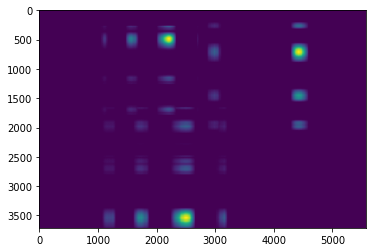

In [28]:
# 索引为 idx 的关键点，在全图上的预测热力图
plt.imshow(heatmap)
plt.show()

## OpenCV可视化

In [29]:
img_bgr = cv2.imread(img_path)

In [30]:
# 检测框的颜色
bbox_color = (150,0,0)
# 检测框的线宽
bbox_thickness = 20
# 关键点半径
kpt_radius = 70
# 连接线宽
skeleton_thickness = 30

In [31]:
# 三角板关键点检测数据集-元数据（直接从config配置文件中粘贴）
dataset_info = {
    'keypoint_info':{
        0:{'name':'angle_30','id':0,'color':[255,0,0],'type': '','swap': ''},
        1:{'name':'angle_60','id':1,'color':[0,255,0],'type': '','swap': ''},
        2:{'name':'angle_90','id':2,'color':[0,0,255],'type': '','swap': ''}
    },
    'skeleton_info': {
        0: {'link':('angle_30','angle_60'),'id': 0,'color': [100,150,200]},
        1: {'link':('angle_60','angle_90'),'id': 1,'color': [200,100,150]},
        2: {'link':('angle_90','angle_30'),'id': 2,'color': [150,120,100]}
    }
}

In [32]:
# 关键点类别和关键点ID的映射字典
label2id = {}
for each in dataset_info['keypoint_info'].items():
    label2id[each[1]['name']] = each[0]

In [33]:
for bbox_idx, bbox in enumerate(bboxes): # 遍历每个检测框

    # 画框
    img_bgr = cv2.rectangle(img_bgr, (bbox[0], bbox[1]), (bbox[2], bbox[3]), bbox_color, bbox_thickness)
    
    # 索引为 0 的框，每个关键点的坐标
    keypoints = data_samples.pred_instances.keypoints[bbox_idx,:,:].astype('int')

    # 画连线
    for skeleton_id, skeleton in dataset_info['skeleton_info'].items(): # 遍历每一种连接
        skeleton_color = skeleton['color']
        srt_kpt_id = label2id[skeleton['link'][0]] # 起始点的类别 ID
        srt_kpt_xy = keypoints[srt_kpt_id]         # 起始点的 XY 坐标
        dst_kpt_id = label2id[skeleton['link'][1]] # 终止点的类别 ID
        dst_kpt_xy = keypoints[dst_kpt_id]         # 终止点的 XY 坐标
        img_bgr = cv2.line(img_bgr, (srt_kpt_xy[0],srt_kpt_xy[1]),(dst_kpt_xy[0],dst_kpt_xy[1]),color=skeleton_color,thickness=skeleton_thickness)
    
    # 画关键点
    for kpt_idx, kpt_xy in enumerate(keypoints): # 遍历该检测框中的每一个关键点
        kpt_color = dataset_info['keypoint_info'][kpt_idx]['color']
        img_bgr = cv2.circle(img_bgr, (kpt_xy[0], kpt_xy[1]), kpt_radius, kpt_color, -1)

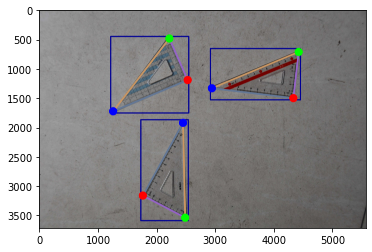

In [34]:
plt.imshow(img_bgr[:,:,::-1])
plt.show()

In [35]:
cv2.imwrite('outputs/F2_opencv.jpg', img_bgr)

True

## MMPose官方可视化工具`visualizer`

In [36]:
# 半径
pose_estimator.cfg.visualizer.radius = 50
# 线宽
pose_estimator.cfg.visualizer.line_width = 40
visualizer = VISUALIZERS.build(pose_estimator.cfg.visualizer)
# 元数据
visualizer.set_dataset_meta(pose_estimator.dataset_meta)

04/04 22:35:24 - mmengine - WARNING - `Visualizer` backend is not initialized because save_dir is None.


In [37]:
# 元数据
# pose_estimator.dataset_meta

In [38]:
img = mmcv.imread(img_path)
img = mmcv.imconvert(img, 'bgr', 'rgb')

img_output = visualizer.add_datasample(
            'result',
            img,
            data_sample=data_samples,
            draw_gt=False,
            draw_heatmap=True,
            draw_bbox=True,
            show=False,
            show_kpt_idx=True,
            wait_time=0,
            out_file='outputs/F2_visualizer.jpg',
            kpt_thr=0.3
)

In [39]:
img_output.shape

(7424, 5568, 3)

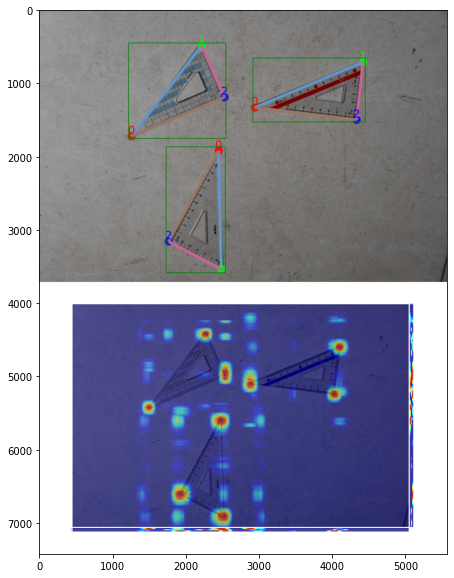

In [40]:
plt.figure(figsize=(10,10))
plt.imshow(img_output)
plt.show()